# Symbolic Regression
This notebook shows how to extract a low dimensional mathematical expression that approximates the committors the `RCModel` learned in the iterative sampling phase.

We will:
1. Load the previous simulation data from the `openpathsampling` storage and load the most recent `RCModel` associated with that simulation
2. Do a HIPR analysis to identify the most relevant coordinates as found by the `RCModel`
3. Use the few most important coordinates as only inputs to the symbolic regression

Note however, that the symbolic regression is not strictly speaken a fit of the `RCModel`, but instead we use the same maximum likeliehood loss function as the `RCModels` to find the most likely reaction coordinate in the reduced space in which the symbolic regression lives. The result is therefore independant of the previously used `RCModel` and we do not introduce any biases through possible overfitting/underfitting in the sampling phase.

In [ ]:
# to be able tu run multiple notebooks in paralell:
# tell tf to not grab the whole GPU memory available
import tensorflow as tf
if tf.version.VERSION.startswith('2.'):
    # tell tf to use only the GPU mem it needs
    gpus = tf.config.experimental.list_physical_devices('GPU')
    print('available GPUs: ', gpus)
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    from tensorflow.keras import backend as K

else:
    conf = tf.compat.v1.ConfigProto()
    conf.gpu_options.allow_growth = True
    conf.gpu_options.per_process_gpu_memory_fraction = 0.25
    #tf.enable_eager_execution(config=conf)\n",
    sess = tf.compat.v1.Session(config=conf)
    from tensorflow.keras import backend as K
    K.set_session(sess)

In [1]:
%matplotlib inline

In [2]:
import os
import arcd
import numpy as np
import matplotlib.pyplot as plt
import openpathsampling as paths
import openpathsampling.engines.toy as toys
from functools import reduce

In [3]:
# load a helper class for visualization of the toy system
%run resources/toy_plot_helpers.py

In [4]:
# change to the folder in which we previously sampled
wdir = 'toy_tps_keras'
if wdir is not None:
    os.chdir(wdir)

## 1. Load what we need from the simulation
- trainset (to be able to calculate the HIPR and to train the symbolic regression on)
- `RCModel` (for HIPR analysis only)
- toy PES for plotting

In [5]:
storage_file = '22dim_toy_keras.nc'
storage = paths.Storage(storage_file, 'r')

In [6]:
toy_eng = storage.engines[0]

In [7]:
stateA = storage.volumes.find('StateA')
stateB = storage.volumes.find('StateB')

In [8]:
pes_list = []
# get the part of the potential that lies in x/y plane for plotting
ow = toy_eng.topology.pes.pes1.pes1.pes1
print('OuterWalls: ', ow)
pes_list.append(ow)

gauss1 = toy_eng.topology.pes.pes1.pes1.pes2
print('gaussian 1: ', gauss1)
pes_list.append(gauss1)

gauss2 = toy_eng.topology.pes.pes1.pes2
print('gaussian 2: ', gauss2)
pes_list.append(gauss2)

# define the potential function for plotting using the previously retrieved parameters
def OuterWalls(x):
    return np.sum(pes_list[0].sigma[:2] * (x - pes_list[0].x0[:2])**6, axis=-1)

def GaussA(x):
    return pes_list[1].A * np.exp(np.sum(- pes_list[1].alpha[:2] * (x - pes_list[1].x0[:2])**2, axis=-1))

def GaussB(x):
    return pes_list[2].A * np.exp(np.sum(- pes_list[2].alpha[:2] * (x - pes_list[2].x0[:2])**2, axis=-1))

def V(x):
    return OuterWalls(x) + GaussA(x) + GaussB(x)

OuterWalls:  <openpathsampling.engines.toy.pes.OuterWalls object at 0x7f6e6697be10>
gaussian 1:  <openpathsampling.engines.toy.pes.Gaussian object at 0x7f6e6697be50>
gaussian 2:  <openpathsampling.engines.toy.pes.Gaussian object at 0x7f6e6697bdd0>


### Plot the PES

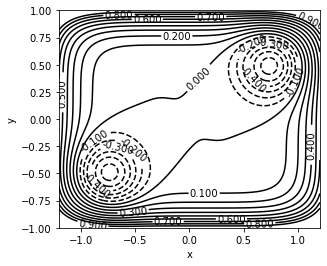

In [9]:
x = np.linspace(-1.2, 1.2, 240)
y = np.linspace(-1., 1., 200)
X, Y = np.meshgrid(x,y)

coord = np.array([[xv, yv] for yv in y for xv in x])
V_val = V(coord)
V_val = V_val.reshape((len(y), len(x)))

fig, axs = plt.subplots(1)
#mapp = axs.imshow(V_val, extent=[x[0], x[-1], y[0], y[-1]], origin='lower')
axs.set_xlabel('x')
axs.set_ylabel('y')
#fig.colorbar(mapp)

levels = np.arange(-1.5 , 1., 0.1)
CS = axs.contour(X, Y, V_val, levels, colors='k')
axs.clabel(CS, inline=1, fontsize=10, )
axs.set_aspect('equal')


### Load the trainingset 

In [12]:
# there is a number of possibly useful utility functions in arcd.base.utils which work for all `RCModels` independently of the underlying ML model
trainset = arcd.base.utils.load_trainset(storage)

### Load the model

In [13]:
# the last/most recent RCModel of any simulation will be saved as "${storage_file_name}_RCmodel.pckl" right besides the ops storage at the end of the simulation
# in case you want to load a previous/ another model they will be saved in fixed intervals as "${storage_file_name}_RCmodel_at_step${STEPNUM}.pckl"
model_file = storage_file + '_RCmodel.pckl'
# passing the open ops storage enables us to load e.g. the ops descriptor_transform the model uses from there
model = arcd.base.utils.load_model(model_file, storage=storage)

## 2. Do a HIPR analysis to find the most relevant input coordinates

In [14]:
hipr = arcd.analysis.HIPRanalysis(model, trainset)
hipr_plus_losses = hipr.do_hipr_plus()

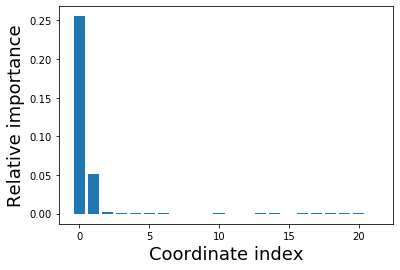

In [17]:
# plot the loss differences
fig, axs = plt.subplots(1)
plt.bar(np.arange(len(hipr_plus_losses)-1), hipr_plus_losses[:-1] - hipr_plus_losses[-1]) 
plt.xlabel('Coordinate index', size=18)
plt.ylabel('Relative importance', size=18);
# Note that this is a bit pointless for the toy system, as we know that only the first two are relevant
# But it is nice to see that the RCmodel thinks so too :)

## 3. Symbolic regression

In [18]:
# necessary imports
import pyaudi
import sympy as sp

In [21]:
# find the most relevant coordinates, i.e. where loss difference is maximal
loss_plus_diffs = hipr_plus_losses[:-1] - hipr_plus_losses[-1]
max_idxs = np.argsort(loss_plus_diffs)[::-1]
print('Most relevant coordinate indices: ', max_idxs)
print('Should have 0, 1 as first two entries for the toy system.')
# get the descriptors and shot results as numpy arrays from the training set
descriptors = trainset.descriptors
shot_results = trainset.shot_results

Most relevant coordinate indices:  [ 0  1  2  6 14 17 13 19 18  5 20  4 16  3 10  7 11 21 12  8  9 15]
Should have 0, 1 as first two entries for the toy system.


In [22]:
n = 2  # lets take the two most relevant inputs for the symbolic regression,
       # i.e. our resulting low dimensional reaction coordinate expression will be of dimension 2
skip = 10  # take only every 10th step to speed up stuff a bit, [should not change the result drastically as subsequent shooting points are correlated anyways]

# create training inputs for symbolic regression
# the training inputs need to be gdual_vdoubles, since we need to be able to calculate gradients w.r.t. them
xt = [pyaudi.gdual_vdouble(descriptors[::skip, i]) for i in max_idxs[:n]]
# the targets can (and should for efficiency) also be numpy arrays, since we need no gradients for them
yt = shot_results[::skip]

# take all points for calculating the test loss
xtf = [pyaudi.gdual_vdouble(descriptors[:, i]) for i in max_idxs[:n]]
ytf = shot_results[:]

In [23]:
# initialize symbolic regression expression with random conectivity and random edge weights
expression = arcd.symreg.initialize_random_expression(n,  # n inputs
                                                      1,  # 1 output: p_B
                                                      kernels=['sum', 'diff', 'mul', 'div', 'log', 'exp'], # potentially allowed elementary mathematical operations
                                                                                                           # our final expression will be a combination of those operations
                                                                                                           # could also add 'sin' and 'sig' for sine and sigmoid
                                                     )

In [24]:
# choose a loss function and a complexity regularization
lossFX = arcd.symreg.losses.binom_loss
complex_fx = lambda ex: arcd.symreg.losses.operation_count(ex, fact=0.00001)
complex_fx_reduced = lambda ex: arcd.symreg.losses.operation_count(ex, fact=0.000001)

# there are also other complexity penalties available
# arcd.symreg.losses.active_genes_count : penalizes number of actives genes in the expression
# arcd.symreg.losses.l1_regularization : sparsity regularization on the edge weights
# arcd.symreg.losses.l2_regularization : penalize length of the vector of edge weights (not really a complexity penalty, but sometimes useful)

In [25]:
# here we optimize the expression
lossL = []
genesL = []
weightsL = []
n_iter = 4  # do it n_iter times in a row to get a feeling for the stability of the result
for _ in range(n_iter):
    # initilize a new random expression every time, otherwise we would start the genetic algorithm from the previously optimized individual
    # (which would be the same as running one optimization n_iter times longer)
    expression = arcd.symreg.initialize_random_expression(n, 1, kernels=['sum', 'diff', 'mul', 'div', 'log', 'exp'])
    loss, genes, weights = arcd.symreg.optimize_expression(expression, # expression to optimize
                                                           4,  # number of mutants to create in every generation
                                                           100, # maximum number of generations
                                                           xt,  # training points
                                                           yt,  # training targets, i.e. shot results 
                                                           lossFX,  # either binomial loss for 2 state (predicting only p_B) or multinomial loss for N state
                                                           complexity_regularization=complex_fx,  # the combined lambda function(s) we use for complexity regularization
                                                                                                  # all of these do not need gradients w.r.t the weights
                                                           weight_regularization=None,  # combined lambda functions for weight regularizations
                                                                                        # these need and calculate the gradients w.r.t. edge weights
                                                           newtonParams={'steps':100},  # newton steps is what makes up most of the runtime,
                                                                                        # however if it is to small expressions will not converge in parameter space
                                                                                        # this can be diagnosed if we have many similar expression with different coeffs
                                                          )
    # store loss, genes and weights of the best expression found in every round
    lossL.append(loss)
    genesL.append(genes)
    weightsL.append(weights)

/home/tb/hejung/.conda/envs/arcd_dublin/lib/python3.7/site-packages/numpy/linalg/linalg.py:2116: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


In [26]:
# print the resulting equations for every round
for l, g, w in zip(lossL, genesL, weightsL):
    # we take a dummy expression and set it to the optimal parameters we found previously
    expression.set(g)  # set genes to the best we found
    expression.set_weights(w)  # also set edge weights of the expression
    print('loss with regularization on training data: ', l)  # this is the loss we had in training, includes all regularizations and is calculated only over the reduced dataset
    print('losss without regularization on all data: ', sum(lossFX(expression, xtf, ytf).constant_cf))  # this is the loss of the expression on the full dataset without regularizations
                                                                                                        # i.e. the actual likeliehood
    print(expression.simplify(['x{:d}'.format(idx) for idx in max_idxs[:n]], subs_weights=True))  # print the formula, subsitute edge weights to numbers
    print()

loss with regularization on training data:  0.5472077056061119
losss without regularization on all data:  0.5402575912169462
[11.4002197857859*x0**2*x1 + x0*(8.38484284326019*x1**2 + 3.2180964563383) + 0.886345383979576*x1]

loss with regularization on training data:  0.5964897473302384
losss without regularization on all data:  0.5804666500466934
[2.29618200840402*x0**3]

loss with regularization on training data:  0.5737430155900084
losss without regularization on all data:  0.5503253324268742
[2.64589039981365*x0 + 1.41669865209872*x1]

loss with regularization on training data:  0.539493632687793
losss without regularization on all data:  0.5337616532825246
[3.583941481172*x0*exp(6.03039017328974*x0*x1)]



### Plot the committor predicted by the symbolic regression expression onto the potential

In [28]:
# Note that since the symbloic regression predicts log_probabilities we will need to take the sigmoid to get p_B
# we use scipy for that
from scipy.special import expit as sigmoid

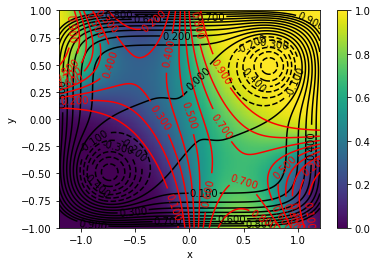

In [30]:
# choose an expression to plot and get the weights + genes we stored
expr_idx = 0
genes = genesL[expr_idx]
weights = weightsL[expr_idx]
# set genes and weights as above
expression.set(genes)
expression.set_weights(weights)

# genereate the potential surface plotting data
x = np.linspace(-1.2, 1.2, 240)
y = np.linspace(-1., 1., 200)
X, Y = np.meshgrid(x,y)
# create an array of coordinate value pairs to calculate V(x,y)
# do it as one big 1d array as it is much faster
coord = np.array([[xv, yv] for yv in y for xv in x])
V_val = V(coord)
# unwrap to a 2d array for plotting
V_val = V_val.reshape((len(y), len(x)))

# actual plotting
fig, axs = plt.subplots(1)
axs.set_xlabel('x')
axs.set_ylabel('y')

# plot isolines of the potential
levels = np.arange(-1.5 , 1., 0.1)
CS = axs.contour(X, Y, V_val, levels, colors='k')
axs.clabel(CS, inline=1, fontsize=10, )
axs.set_aspect('equal')

# generate RC plotting data
coord_gdual = [pyaudi.gdual_vdouble(coord[:, i]) for i in range(coord.shape[1])]
rc = expression(coord_gdual)  # this is now a list of gdual_vdoubles
# since we trained with the binomial loss the RC only has one entry, the RC towards B
rc = np.array(rc[0].constant_cf) # convert to a numpy array, i.e. take only the values and ignore the higher order derivates
# again unwrap to 2d array for plotting
rc_mat = rc.reshape((len(y), len(x)))

# actual plotting
# first as color gradient
mapp = axs.imshow(sigmoid(rc_mat), extent=[x[0], x[-1], y[0], y[-1]], origin='lower')
# also plot isolines of p_B in red
levels = np.arange(0. , 1., 0.1)
CS = axs.contour(X, Y, sigmoid(rc_mat), levels, colors='r')
axs.clabel(CS, inline=1, fontsize=10, )
# draw a colorbar
fig.colorbar(mapp)